# Simiosis gia Grid
- o skopos tou na dimiourgisw ena grid einai gia na miosw kata poli to sinolo ton simion sto disance join
- auto epitinxanete ftiaxnontas ena MBB pernontas ta min ton max(x,y) kai apo ta 2 data sets kathos kai ta max apo ta min(x,y) me tin logiki oti osa simia einai ektos tou min max x enos apo ta 2 dataset den ikanopoioun tin sinthiki theta.
- stin sinexia tha prepei na kanw spatial join to grid kai me ta 2 datasets gia na vrw se poio grid paei kathe simio
- meta tha aporipsw osa grids den exoun kanena

### Xrisima stixia na periexei ena grid
- gridId
- polygon
- TODO Check id x an y needed for partitioning reasons

### Idea gia grid filtering
- Na kanw spatial join mono sto dataset me ta ligotera simia prokimenou na filtrarw ta grids pou den exeoun kanena simio apo to Dataset auto
- Me auton ton tropo epitinxanw na kanw mikrotero spatial join sto dataset me tis perisoteres eggrafes
- auto vasizete sto

# Simiosis gia partitioning
- prepei na xorisw ta data mou se ola ta mixanimata prin ksekinisw to spatial join
- episis prepei na xorisw kai ta grids omiomorfa se ola ta mixanimata
- enas tropos gia na ta xorisw tha mporouse na einai to X. Diladi na vrw ta max kai min X kai paota 2 datasets gia na vrw to rangekai na kanw range partition os pros x gia ta points
- gia ta grids apo tin all tha eprepe na kanw partition os pros to max X tous oste na simenei oti oti grid einai sto partition exei points mono sto partition auto.
- me auton ton tropo epitinxanoume na exoume ta points kai ta grids tous mirasmena ana mixanima kai na empodisoume tis metakinisis sto diktio

### Pws to kanw auto?
- prepei na dw pws douleui to pratitioning
- pos simperiferete to join sto partitioning
- prepei na dw an ipostirizei kati tetoio i vivliothiki

## Imports

In [1]:
# Main  Imports
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.core.display import display
import time

# Local App Imports
from utils import spatialUtils as utils

# Spark Imports
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, LongType


# Sedona Imports
from sedona.utils import KryoSerializer, SedonaKryoRegistrator
from sedona.register import SedonaRegistrator
from sedona.sql.types import GeometryType

# Python shapely imports
import shapely.geometry as sg
from shapely.geometry import Polygon
from descartes import PolygonPatch
import geog
import shapely.speedups
shapely.speedups.enable() # this makes some spatial queries run faster

## Load Dataset

In [2]:
# full program timer
total_time = time.time()

test_sample_A_path = "../testData/ais_one_hour.csv"
test_sample_B_path = "../testData/ais_one_hour2.csv"

# test_sample_path = "../testData/ais_one_month.csv"


# create sedona spark session
spark = SparkSession. \
    builder. \
    appName('appName'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.0.0-incubating,'
           'org.datasyslab:geotools-wrapper:geotools-24.0'). \
    getOrCreate()

SedonaRegistrator.registerAll(spark)

# Load CSV File
df_a = spark.read.csv(header="True", inferSchema="True", path=test_sample_A_path)
df_a.show(10)

df_b = spark.read.csv(header="True", inferSchema="True", path=test_sample_B_path)
df_b.show(10)

+---+--------------------+----------+---------+
|_c0|                 _id|         X|        Y|
+---+--------------------+----------+---------+
|  0|60039bef2bc024099...|  -4.50088| 48.35698|
|  1|60039b8f2bc024099...|-4.4970617|48.379555|
|  2|60039b9c2bc024099...|-4.4137635| 48.15062|
|  3|60039bef2bc024099...| -4.500963|48.356915|
|  4|60039bbe2bc024099...| -4.474253|48.341007|
|  5|60039bef2bc024099...| -4.501045|48.356842|
|  6|60039a6c2bc024099...| -4.497015|48.382206|
|  7|60039c032bc024099...|  -4.56926| 48.13976|
|  8|60039e032bc024099...| -4.476655| 48.38109|
|  9|60039bef2bc024099...| -4.501128|48.356773|
+---+--------------------+----------+---------+
only showing top 10 rows

+---+--------------------+----------+---------+
|_c0|                 _id|         X|        Y|
+---+--------------------+----------+---------+
|  0|600399bc2bc024099...|-4.5935817| 48.13648|
|  1|60039df12bc024099...| -4.758715| 48.06632|
|  2|60039bbe2bc024099...| -4.472955|48.340054|
|  3|60039e102

## Filter Dataset for Test Reasons
- arxika tha periorisoume to dataset stin perioxi x[-6.5,-5] kai y[47.5,49]
- epilegw auto gt kserw oti exei arketa pings

df_a = df_a.filter( (-6 <= df_a.X) & (df_a.X <= -5) & (47.5 <= df_a.Y) & (df_a.Y <= 49))\
    .cache()
print("Total filtered_df_a count {}".format(df_a.count()))
df_a.show(10)

df_b = df_b.filter( (-6.5 <= df_b.X) & (df_b.X <= -5) & (47.5 <= df_b.Y) & (df_b.Y <= 49))\
    .cache()
print("Total filtered_df_b count {}".format(df_b.count()))
df_b.show(10)

In [3]:
df_a = df_a.limit(20000)
df_b = df_b.limit(20000)

## Grid Dataset
Lets create a test grid
- We have to find the MBB from the dataset with less records
- Then we have to create a grid for this dataset (**sos** each grid side has to be equal to theta)
- Then calculate expanded grids for each grid

### Times:
first run --- 4.288848161697388 seconds ---

In [4]:
def calculate_MBB_from_sdf(sdf):
    # find min/max X,Y
    mbb_row = sdf.agg(
        F.max(sdf.X),
        F.min(sdf.X),
        F.max(sdf.Y),
        F.min(sdf.Y),
    ).collect()[0]
    print("print mbb: {}".format(mbb_row))
    #calculate grid for dataset
    return utils.getPolyGrid(mbb_row["min(X)"],mbb_row["min(Y)"],mbb_row["max(X)"],mbb_row["max(Y)"], theta=10)



In [5]:
cell_time = time.time()

#calculate grid for dataset
grid = calculate_MBB_from_sdf(df_a) if df_a.count() <= df_b.count() else calculate_MBB_from_sdf(df_b)
print("grid len: {}".format(len(grid)))

print("--- %s seconds ---" % (time.time() - cell_time))


print mbb: Row(max(X)=-0.066665, min(X)=-7.0706515, max(Y)=50.431885, min(Y)=46.516026)
grid len: 6993
--- 7.310056924819946 seconds ---


## Plot Grid And Points

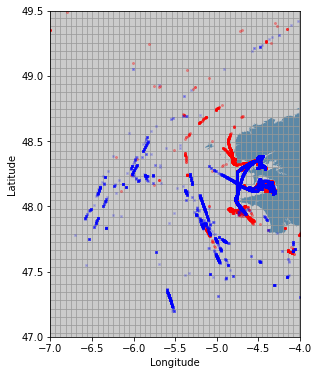

In [6]:
# print grids
ax = utils.createAXNFigure()
BLUE = '#6699cc'
GRAY = '#999999'
for cell in grid:
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.5, zorder=2))

for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

for row in df_b.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Create Grid RDD or DF

In [7]:
grid_df = spark.createDataFrame(grid)
grid_df.printSchema()
print(grid_df.schema)
grid_df.show(10)

root
 |-- exp_grid_maxX: double (nullable = true)
 |-- exp_grid_maxY: double (nullable = true)
 |-- exp_grid_minX: double (nullable = true)
 |-- exp_grid_minY: double (nullable = true)
 |-- grid_id: long (nullable = true)
 |-- grid_maxX: double (nullable = true)
 |-- grid_maxY: double (nullable = true)
 |-- grid_minX: double (nullable = true)
 |-- grid_minY: double (nullable = true)

StructType(List(StructField(exp_grid_maxX,DoubleType,true),StructField(exp_grid_maxY,DoubleType,true),StructField(exp_grid_minX,DoubleType,true),StructField(exp_grid_minY,DoubleType,true),StructField(grid_id,LongType,true),StructField(grid_maxX,DoubleType,true),StructField(grid_maxY,DoubleType,true),StructField(grid_minX,DoubleType,true),StructField(grid_minY,DoubleType,true)))
+-------------+-------------+-------------+-------------+-------+---------+---------+---------+---------+
|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|
+-------------+-----

## Link Points tou Grids
- **Approach 1:** Test databricks code for spatial join from link
- **Approach 2:** perform spatial join in order to link points with grids
- **Approach 3:** perform spatial join without using intersection. use where statement on join and check if point is within grid box

### Results
It seems that approach 3 is 3 times faster than approach 2 because we dont need to check for intersection using apache
sedona because we use squares/grids as polygons and in this case we can easily check if point intersect with the square
grid by chacking max and min X,Y respectively. Despite that we dont need to use UDF function in order to conver X,Y coords into sapely point

### Approach 3

In [8]:
# timing procedure
start_time = time.time()

df_a.createOrReplaceTempView("points")
grid_df.createOrReplaceTempView("grids")

spatial_join_result = spark.sql(
    """
        SELECT *
        FROM points AS P join grids AS G
        WHERE P.X >= G.grid_minX and P.X <= G.grid_maxX
         and P.Y >= G.grid_minY and P.Y <= G.grid_maxY
    """
).cache() # cache results to avoid perform join again



print("--- %s seconds ---" % (time.time() - start_time))

# print some stats
spatial_join_result.show()
print(spatial_join_result.count())

--- 0.22771000862121582 seconds ---
+-----+--------------------+----------+---------+-------------+-------------+-------------+-------------+-------+---------+---------+---------+---------+
|  _c0|                 _id|         X|        Y|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|
+-----+--------------------+----------+---------+-------------+-------------+-------------+-------------+-------+---------+---------+---------+---------+
|  411|600398982bc024099...| -7.070542|49.238495|     -6.86916|      49.3452|     -7.20844|     49.10163|     19| -7.00695| 49.25527| -7.07065| 49.19157|
| 3611|600398982bc024099...|-6.9999585| 49.35194|      -6.8051|     49.47261|     -7.14509|     49.22904|     80| -6.94324| 49.38268| -7.00695| 49.31897|
| 3620|600398982bc024099...|-6.9997835|49.352276|      -6.8051|     49.47261|     -7.14509|     49.22904|     80| -6.94324| 49.38268| -7.00695| 49.31897|
| 3626|600398982bc024099...| -6.999658|4

## Spatial join Approach 2 stats
- find count
- find pings per grid
- filter grids with 0 points

### SOS
Otan kanoume chaining functions mporoume na exoume access se colum apo to proigoumeno function kanontas F.col("coll_name")

In [9]:
print("spatial join count: {}".format(spatial_join_result.count()))

# find pings per grid
filtered_grid = spatial_join_result.groupby(["grid_id", "grid_maxX", "grid_maxY", "grid_minX", "grid_minY", "exp_grid_maxX", "exp_grid_maxY", "exp_grid_minX", "exp_grid_minY"])\
    .count()\
    .filter(F.col("count") > 0)\
    .cache()

filtered_grid.show(10)

print("filtered spatial join count: {}".format(filtered_grid.count()))

spatial join count: 20000
+-------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+
|grid_id|grid_maxX|grid_maxY|grid_minX|grid_minY|exp_grid_maxX|exp_grid_maxY|exp_grid_minX|exp_grid_minY|count|
+-------+---------+---------+---------+---------+-------------+-------------+-------------+-------------+-----+
|   3416| -3.56697| 49.57379| -3.63067| 49.51008|     -3.42829|     49.66372|     -3.76936|     49.42015|    1|
|   1347| -5.66918| 48.93675| -5.73288| 48.87305|     -5.53227|     49.02668|     -5.86979|     48.78312|    2|
|   3917| -3.05734| 49.76489| -3.12105| 49.70119|     -2.91811|     49.85483|     -3.26028|     49.61126|    2|
|   1918| -5.09585| 48.68194| -5.15955| 48.61824|     -4.95964|     48.77187|     -5.29576|      48.5283|    4|
|   3217| -3.75808| 50.21082| -3.82178| 50.14711|     -3.61755|     50.30075|     -3.96231|     50.05718|    3|
|   2235| -4.77733| 48.55453| -4.84104| 48.49083|     -4.64146|     48.64446| 

## Plot points with filtered grids

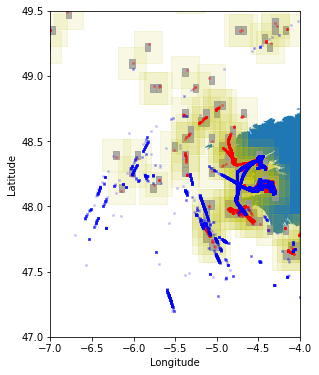

In [10]:
# print grids
ax = utils.createAXNFigure()
BLUE = '#6699cc'
GRAY = '#999999'

for cell in filtered_grid.collect():
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    exp_grid = utils.createPolyFromPoints(cell["exp_grid_minX"], cell["exp_grid_maxX"], cell["exp_grid_minY"], cell["exp_grid_maxY"])

    ax.add_patch(PolygonPatch(exp_grid, fc='y', ec="y", alpha=0.1, zorder=2))
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.8, zorder=2))


for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

for row in df_b.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Perform Spatial Join With Point_set B And expanded gids

By performing this spatial join we can filter points not in expanded grids (if exist)
and keep only those points who have a chance to satisfy condition theta

for This spatial join we choose approach 3 from previous spatial join (datasetA with grids)

In [11]:
# timing procedure
start_time = time.time()

df_b.createOrReplaceTempView("points_B")
filtered_grid.createOrReplaceTempView("grids")

spatial_join_b_result_new = spark.sql(
    """
        SELECT P._id, P.X, P.Y, G.grid_id as exp_grid_id, G.grid_minX, G.grid_maxX, G.grid_minY, G.grid_maxY
        FROM points_B AS P, grids AS G
        WHERE P.X >= G.exp_grid_minX and P.X <= G.exp_grid_maxX
         and P.Y >= G.exp_grid_minY and P.Y <= G.exp_grid_maxY
    """
).withColumn("grid_id", F.when((F.col("X") >= F.col("grid_minX")) &
                                  (F.col("X") <= F.col("grid_maxX")) &
                                  (F.col("Y") >= F.col("grid_minY")) &
                                  (F.col("Y") <= F.col("grid_maxY")),F.col("exp_grid_id"))
                           .otherwise(None))\
    .cache() # cache results to avoid perform join again

spatial_join_b_result_new.show()
print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+----------+--------+-----------+---------+---------+---------+---------+-------+
|                 _id|         X|       Y|exp_grid_id|grid_minX|grid_maxX|grid_minY|grid_maxY|grid_id|
+--------------------+----------+--------+-----------+---------+---------+---------+---------+-------+
|600399bc2bc024099...|-4.5935817|48.13648|       2303| -4.77733| -4.71363| 48.17231| 48.23602|   null|
|600399bc2bc024099...|-4.5935817|48.13648|       2367| -4.71363| -4.64993| 48.10861| 48.17231|   null|
|600399bc2bc024099...|-4.5935817|48.13648|       2619| -4.45882| -4.39511| 48.10861| 48.17231|   null|
|600399bc2bc024099...|-4.5935817|48.13648|       2430| -4.64993| -4.58622| 48.10861| 48.17231|   2430|
|600399bc2bc024099...|-4.5935817|48.13648|       2556| -4.52252| -4.45882| 48.10861| 48.17231|   null|
|600399bc2bc024099...|-4.5935817|48.13648|       2555| -4.52252| -4.45882| 48.17231| 48.23602|   null|
|600399bc2bc024099...|-4.5935817|48.13648|       2493| -4.58622| -4.52252

def createPoints(longitude, latitude):
  return sg.Point(longitude, latitude)

createPoints_udf = F.udf(createPoints,GeometryType())

## Get filtered point set B


In [12]:
print("spatial join count: {}".format(spatial_join_b_result_new.count()))

# find pings per grid
geom_b_df = spatial_join_b_result_new.groupby(["_id", "X", "Y"])\
    .count()\
    .filter(F.col("count") > 0)\
    .cache()

geom_b_df.show(10)

print("filtered spatial join count: {}".format(geom_b_df.count()))

spatial join count: 168340
+--------------------+----------+---------+-----+
|                 _id|         X|        Y|count|
+--------------------+----------+---------+-----+
|60039bdc2bc024099...| -4.666623| 48.30852|   10|
|60039c032bc024099...| -4.600867|48.140213|    8|
|60039b9c2bc024099...|-4.4894485|48.136444|    8|
|60039df12bc024099...| -4.771415|48.051918|   14|
|60039c8d2bc024099...| -4.558727|48.339714|   10|
|60039e102bc024099...|  -4.63214|48.320415|   12|
|60039df12bc024099...|-4.7701316|48.039417|   14|
|600399d42bc024099...|-4.4608483| 48.16365|   14|
|600399d42bc024099...|-4.4450984|  48.1658|   12|
|600399c32bc024099...|-4.4982815|48.380295|    8|
+--------------------+----------+---------+-----+
only showing top 10 rows

filtered spatial join count: 19356


## Plot plot filtered points B
plot points From Pointset B That are in expanded grids

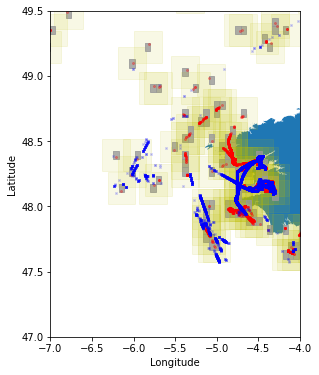

In [13]:
# print grids
ax = utils.createAXNFigure()
BLUE = '#6699cc'
GRAY = '#999999'

for cell in filtered_grid.collect():
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    exp_grid = utils.createPolyFromPoints(cell["exp_grid_minX"], cell["exp_grid_maxX"], cell["exp_grid_minY"], cell["exp_grid_maxY"])

    ax.add_patch(PolygonPatch(exp_grid, fc='y', ec="y", alpha=0.1, zorder=2))
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.8, zorder=2))


for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

for row in geom_b_df.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Plot points from B that are in grid

In [14]:
filltered_df = spatial_join_b_result_new.filter(F.col("grid_id").isNotNull())
filltered_df.show()

+--------------------+----------+---------+-----------+---------+---------+---------+---------+-------+
|                 _id|         X|        Y|exp_grid_id|grid_minX|grid_maxX|grid_minY|grid_maxY|grid_id|
+--------------------+----------+---------+-----------+---------+---------+---------+---------+-------+
|600399bc2bc024099...|-4.5935817| 48.13648|       2430| -4.64993| -4.58622| 48.10861| 48.17231|   2430|
|60039df12bc024099...| -4.758715| 48.06632|       2305| -4.77733| -4.71363| 48.04491| 48.10861|   2305|
|60039bbe2bc024099...| -4.472955|48.340054|       2553| -4.52252| -4.45882| 48.29972| 48.36342|   2553|
|60039e102bc024099...| -4.678545|48.304527|       2364| -4.71363| -4.64993| 48.29972| 48.36342|   2364|
|600399bc2bc024099...|  -4.59364| 48.13646|       2430| -4.64993| -4.58622| 48.10861| 48.17231|   2430|
|60039c032bc024099...| -4.592973|48.134605|       2430| -4.64993| -4.58622| 48.10861| 48.17231|   2430|
|60039b9c2bc024099...| -4.462722| 48.13622|       2556| -4.52252

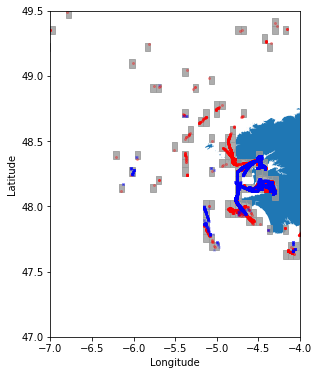

In [15]:
# print grids
ax = utils.createAXNFigure()
BLUE = '#6699cc'
GRAY = '#999999'

for cell in filtered_grid.collect():
    grid_poly = utils.createPolyFromPoints(cell["grid_minX"], cell["grid_maxX"], cell["grid_minY"], cell["grid_maxY"])
    # exp_grid = utils.createPolyFromPoints(cell["exp_grid_minX"], cell["exp_grid_maxX"], cell["exp_grid_minY"], cell["exp_grid_maxY"])

    # ax.add_patch(PolygonPatch(exp_grid, fc='y', ec="y", alpha=0.1, zorder=2))
    ax.add_patch(PolygonPatch(grid_poly, fc=GRAY, ec=GRAY, alpha=0.8, zorder=2))


for row in df_a.collect():
  ax.plot(row.X, row.Y, marker='o', markersize=2, alpha=0.3, c='r')

for row in filltered_df.collect():
  ax.plot(row.X, row.Y, marker='x', markersize=2, alpha=0.3, c='b')


plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.show()

## Find matching points/pairs

As a first filter of matching point we use the fact that each pair point in the same
grid between 2 datasets satisfied the theta condition so:
- We perform a filter on point set B in order to keep only those points that has been
assigned in a grid
- then we perform a simple join with points from point set A based on grid id to find all
valid pairs given by grids
- then write the result into a file (override result if file exits)

### SOS gia tin ilopoiisi
- to filtrarisma tha ginei kratontas osa point exoun idio grid kai expanded grid id

In [16]:
# timing procedure
start_time = time.time()

filtered_a_results = spatial_join_result\
    .select(F.col("_id"), F.col("grid_id"))\
    .withColumnRenamed("_id","a_id")

filtered_b_results = spatial_join_b_result_new\
    .filter(F.col("grid_id") == F.col("exp_grid_id"))\
    .select(F.col("_id"), F.col("grid_id"))\
    .withColumnRenamed("_id","b_id")

ta = filtered_a_results.alias('ta')
tb = filtered_b_results.alias('tb')

first_result = ta.join(tb, ta.grid_id == tb.grid_id)\
    .select(F.col("a_id"), F.col("b_id"))

# write file
print(first_result.count())#.write.save("dist_join_result.csv", format="csv", mode="overwrite")

print("--- %s seconds ---" % (time.time() - start_time))

75701415
--- 0.8116741180419922 seconds ---


## Find matching points using expanded grids
Now we have to check for matching pairs between points from point set A that are in
grid and points from pointest B that ar in the same expanded grid and not in the grid

- declare a udf for haversian distance
- **SOS** By experiemrnt we find out that numpy haversine approch is slower than normal one
- first get all points with null grid from joined pointset B


In [17]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    km = r * c
    return float(km)

udf_haversine = F.udf(haversine, DoubleType())
udf_haversine_np = F.udf(haversine_np, DoubleType())

In [18]:
# timing procedure
start_time = time.time()

# register udf func
haversine_dist_udf = F.udf(utils.calculatePointsDistance, DoubleType())

filtered_a_in_exp_grid = spatial_join_result\
    .withColumnRenamed("_id","a_id")\
    .withColumnRenamed("X","a_X")\
    .withColumnRenamed("Y","a_Y")\
    .withColumnRenamed("grid_id","a_grid_id")\
    .select(F.col("a_id"),F.col("a_X"),F.col("a_Y"),F.col("a_grid_id"))\

filtered_b_in_exp_grid = spatial_join_b_result_new.where(F.col("grid_id").isNull())\
    .withColumnRenamed("_id","b_id")\
    .withColumnRenamed("X","b_X")\
    .withColumnRenamed("Y","b_Y")\
    .withColumnRenamed("exp_grid_id","b_exp_grid_id")\
    .select(F.col("b_id"),F.col("b_X"),F.col("b_Y"),F.col("b_exp_grid_id"))\


ta = filtered_a_in_exp_grid.alias('ta')
tb = filtered_b_in_exp_grid.alias('tb')

final_result = ta.join(tb, ta.a_grid_id == tb.b_exp_grid_id)

final_result = final_result.withColumn("haversine_dist", udf_haversine(F.col("a_X"),F.col("a_Y"),F.col("b_X"),F.col("b_Y")))\
    .filter(F.col("haversine_dist") <= 10)
#\
    # .where(createPoints_udf(F.col("a_X"),F.col("a_Y"),F.col("b_X"),F.col("b_Y")) >= 10)#\
    # .select(F.col("a_id"), F.col("b_id"))

# final_result.write.save("dist_join_result.csv", format="csv", mode="append")

final_result.show(10)
print(final_result.count())

print("--- %s seconds ---" % (time.time() - start_time))

+--------------------+----------+---------+---------+--------------------+----------+--------+-------------+------------------+
|                a_id|       a_X|      a_Y|a_grid_id|                b_id|       b_X|     b_Y|b_exp_grid_id|    haversine_dist|
+--------------------+----------+---------+---------+--------------------+----------+--------+-------------+------------------+
|600399d12bc024099...| -4.652525| 48.14122|     2367|600399bc2bc024099...|-4.5935817|48.13648|         2367| 4.405438903812571|
|600399d12bc024099...| -4.654745|48.143135|     2367|600399bc2bc024099...|-4.5935817|48.13648|         2367| 4.598377155374055|
|600399d12bc024099...| -4.663707| 48.15078|     2367|600399bc2bc024099...|-4.5935817|48.13648|         2367| 5.440602736087082|
|600399d12bc024099...| -4.664758|48.151672|     2367|600399bc2bc024099...|-4.5935817|48.13648|         2367|5.5445915004848985|
|600399d12bc024099...|-4.6725216| 48.15872|     2367|600399bc2bc024099...|-4.5935817|48.13648|         2

In [19]:
print("--- TOTAL EXECUTION TIME ---\n--- %s seconds ---" % (time.time() - total_time))



--- TOTAL EXECUTION TIME ---
--- 705.6993837356567 seconds ---
